---
title: 
author:
  - name: Junior Jumbong
    orcid: +33 7 53 86 56 98
    corresponding: true
    email: junior.jumbong@eleve.ensai.fr
    roles:
    
      - Project 
format:
  html:
    code-fold: true
jupyter: python3    
keywords:
  - Zero coupon
  - Obligations
  - Courbe spot
abstract: |
  Lors de la valorisation d'une obligation, il est essentiel de considérer des éléments clés tels que le prix sale (dirty price) et le prix net (clean price), lesquels dépendent de facteurs variés incluant le taux d'intérêt, la maturité et le taux de coupon. Dans cette analyse, nous avons généré la courbe des taux spot en utilisant des obligations zéro coupon et évalué le prix d'une obligation sous l'hypothèse d'une courbe de taux déterministe. Par la suite, nous avons exploré un modèle simplifié de Hull et White, examiné les spécificités d'une obligation munie d'une clause de rappel et discuté des stratégies de couverture contre le risque de taux d'intérêt.

number-sections: true
---

# Introduction 

Une obligation zéro coupon est une obligation dont les intérêts sont versés en totalité à l'échéance de l'emprunt après avoir capitalisé sur toute la période.Elle est mise à un prix inférieur à sa valeur nominale et remboursée à sa valeur nominale complète à l'échéance.Par exemple, une obligation de valeur nominale 1000€ et de maturité pourrait être mise à 680 €. Ce prix inférieur reflète le fait que l'investisseur ne recevra pas d'intérêt annuel. À l'échéance, l'investisseur recevra 1000 €. Il est donc important de savoir calculer le prix d'une obligation zéro. Nous noterons B(t,T) le prix d'une obligation zéro coupon de maturité T à l'instant t. Il a plusieurs applications :
- Il va permettre de construire la courbe de taux zéro coupon.
- Il joue le rôle de facteur d'actualisation. 
- Il est aussi utilisé dans la modélisation du modèle de Hull et White.

La première section de ce document se focalisera sur l'élaboration de la courbe relative aux obligations zéro coupon, à partir de laquelle nous déduirons aisément la courbe des taux zéro coupon. Dans la 2nde partie, nous allons valoriser une obligation. Dans la seconde partie, nous procéderons à la valorisation d'une obligation, en mettant l'accent sur le concept de dirty price et de clean price. Ensuite nous étudier la sensibilité du prix d'une obligation en fonction du taux d'intérêt et du spread de crédit. Enfin, la troisième partie sera consacrée à l'étude d'un modèle simple de Hull et White.

## Préparation des données et Calcul de la courbe des taux de zéro coupon.

L'objectif de cette partie est de construire la courbe spot des taux zéro coupon $r_T$ à partir des données de marché.
Il est donné par la formule suivante :
$$r_T = -\frac{1}{T} \ln B(0,T)$$

La calibration de la courbe de taux se fait par bootstrapping à partir des cotations du marché : 
- CT = cash rates (les cash flow) : Ici c'est la courbe de taux  qui est constatée sur le marché interbancaire 
- FRA = Forward Rate Agreement (les taux forward)
- SWAP = Interest Rate Swap (les taux swap)


In [2]:
#!pip install openpyxl
import numpy as np
np.random.seed(42)
import pandas as pd
from scipy import interpolate
#importer un fichier xlsx : la première feuille

#courses = pd.read_csv('courses.csv')
taux_BBG = pd.read_excel('Taux_BBG.xlsx', sheet_name='Feuil1') 
taux_BBG.head(2)

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq
0,6,MO,EUR006M,3.832000,3.832000,NaN,0,0,3.832000,3.832000,Cash Rates,ACT/360,0
1,7,MO,EUFR0AG,3.718854,3.739146,NaN,0,0,3.718854,3.739146,Serial FRAs,ACT/360,0


#### Création d'une ligne qui sera la première ligne de notre fichier

In [3]:
# calcul du Mid qui est la moyenne entre le bid et l'ask

nouvelle_ligne = pd.DataFrame({
    'Term': [5],  # Supposons que vous voulez ajouter une période de 5 mois au début
    'Unit': ['MO'],
    'Ticker': ['EUR005M'],  # Supposons un ticker pour la nouvelle ligne
    'Bid': [3.9],  # Exemple de valeur Bid
    'Ask': [3.9],  # Exemple de valeur Ask
    'Spread': [None],
    'Bid Spr Val': [0],
    'Ask Spr Val': [0],
    'Final Bid Rate': [None],
    'Final Ask Rate': [None],
    'Rate Type': [None],
    'Daycount': [None],
    'Freq': [None]
}, index=[0])
df = pd.concat([nouvelle_ligne, taux_BBG], ignore_index=True)
df.head(2)

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq
0,5,MO,EUR005M,3.900,3.900,None,0,0,None,None,None,None,None
1,6,MO,EUR006M,3.832,3.832,NaN,0,0,3.832,3.832,Cash Rates,ACT/360,0


### Calcul du Mid qui sera considéré comme les taux de prêt interbancaire.

Pour calculer la courbe de taux à court terme, nous avons besoin du Mid qui est la moyenne entre le bid et l'ask. Nous nous le considérons comme proxy des taux interbancaires par exemple le LIBOR. Il était important de considérer la liquidité de l'instrument. Les écarts plus larges entre le bid et l'ask indiquent une liquidité plus faible.Ce qui pourrait influencer l'approximation du Libor.Pour des raisons de simplicité, nous avons, nous n'avons pas pris en compte la liquidité des instruments.

In [4]:
df['Mid'] = (df['Bid'] + df['Ask']) / 2

In [5]:
# Initialisation des colonnes
df['T'] = 0
df['T1'] = 0
df['T2'] = 0
df['B(0,T)'] = 0

#### Le prix d'une obligation zéro coupon à l'instant $t=0$ qui paie 1 unité monétaire à l'instant 0 est de 1.

In [6]:
# calcule du premier élement de B(0,T)
df['B(0,T)'].astype(int)[0] = 1

### La courbe spot à partir des cash rates c'est-à-dire à court terme.

Sa formule est donnée par :

$$B(0,T) = \frac{1}{(1+\delta*L )}$$

Où $L$ est le taux de prêt interbancaire(Libor par exemple) et $\delta$ est la fraction de l'année.

In [7]:
# Conversion des termes en années

df['T2'] = df['Term'].astype(int)/12

### Calcul de T1 afin de calculer la courbe spot à partir des taux forward.

In [8]:

df['T1'] = df['T2'] - 0.5

### Calcul des différentes dates de maturité

In [9]:
# df['T'] = df['Term'].astype(int)/12 if df['Unit'] == 'MO' else df['Term'].astype(int)
# With apply function
df['T'] = df.apply(lambda x: x['Term']/12 if x['Unit'] == 'MO' else x['Term'], axis=1)
df.head(2)

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq,Mid,T,T1,T2,"B(0,T)"
0,5,MO,EUR005M,3.900,3.900,None,0,0,None,None,None,None,None,3.900,0.416667,-0.083333,0.416667,0
1,6,MO,EUR006M,3.832,3.832,NaN,0,0,3.832,3.832,Cash Rates,ACT/360,0,3.832,0.500000,0.000000,0.500000,0


In [10]:
df['B(0,T1)'] =0
df['T'].astype(int)[0] = 0

df.loc[0, 'B(0,T)'] = 1


df.loc[1,'B(0,T)'] = 1/(1+ df.loc[1,'Mid']/100*0.5)

df.head(2)

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq,Mid,T,T1,T2,"B(0,T)","B(0,T1)"
0,5,MO,EUR005M,3.900,3.900,None,0,0,None,None,None,None,None,3.900,0.416667,-0.083333,0.416667,1.0000,0
1,6,MO,EUR006M,3.832,3.832,NaN,0,0,3.832,3.832,Cash Rates,ACT/360,0,3.832,0.500000,0.000000,0.500000,0.9812,0


Dans la partie ci-dessus, nous avons calculé la courbe spot à partir des cash rates. Nous allons maintenant calculer la courbe spot à partir des taux forward et les taux swap. Nous pourrons ainsi prolonger la courbe spot jusqu'à 50 ans par des interpolations linéaires.

### Création d'un dataframe pour le prolongement de la courbe de spot sur 50 ans.

In [11]:
# creation d'un dataframe qui va  prolonger le dataframe data_month jusqu'à 50 ans

import pandas as pd
Nombre_year = 51
terms = [0,6, 7, 8, 9, 10, 11, 12, 15, 18] + list(range(2,Nombre_year))
units = ['MO' if i < 10 else 'YR' for i in range(len(terms))]

data_50 = pd.DataFrame({
    'Term': terms,
    'Unit': units
})

data_final = pd.merge(data_50, df, how='left', on=['Term', 'Unit'])

data_final 

#data_final['B(0,T)'][0] =1
data_final.loc[0, 'B(0,T)'] = 1
#data_final['T'][0] = 0
data_final.loc[0, 'T'] = 0
data_final.head(2)




,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq,Mid,T,T1,T2,"B(0,T)","B(0,T1)"
0,0,MO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0000,NaN
1,6,MO,EUR006M,3.832,3.832,NaN,0.0,0.0,3.832,3.832,Cash Rates,ACT/360,0,3.832,0.5,0.0,0.5,0.9812,0.0


###  Interpolation des valeurs de Mid qui ont des valeurs manquantes.

Nous avons utilisé le Mid comme proxy des taux interbancaires. Il représente la moyenne arithmétique entre le "ask" et le "bid".Nous avons utilisé la méthode de l'interpolation linéaire pour remplir les valeurs manquantes.  

In [12]:
from scipy.interpolate import interp1d

nan_indices = data_final['Mid'][data_final['Mid'].isna()].index
valid_data = data_final.dropna(subset=['Mid'])
function = interp1d(valid_data.index, valid_data['Mid'], fill_value='extrapolate')
for nan_index in nan_indices:
    data_final.at[nan_index, 'Mid'] = function(nan_index)
   

Le code ci-dessous va permettre de prolonger la courbe des obligations spot jusqu'à 50 ans. Nous avons ainsi propagé des valeurs de la colonne T jusqu'à 50 ans. 

In [13]:


last_t = data_final['T'].iloc[0]
for i in range(len(data_final)):
    if pd.isna(data_final.loc[i, 'T']):
        last_t += 1
        data_final.loc[i, 'T'] = last_t
    else:
        last_t = data_final.loc[i, 'T']


###  Courbe d'obligation spot moyen et long terme

En moyen terme, la courbe spot est donnée à partir des taux forward par la formule suivante:

$$B(0,T+\delta) = \frac{B(0,T)}{(1+\delta*f )}$$

où $f$ est le taux forward et $\delta$ est la fraction de l'année. Un prêt forward est un engagement entre 2 parties de vendre ou d'acheter un instrument financier à une date ultérieure et à un prix déterminé à l'avance.

En long terme, la courbe spot est donnée à partir des taux swap.Un contrat swap est un contrat d'échange de flux financiers entre deux parties. Un swap de taux est utilisé pour échanger des taux d'intérêt entre deux parties.
La courbe spot est donnée par la formule suivante:

$$B(0,T_n) = \frac{1 -S_{T_n} \sum_{i=1}^{n-1} \delta_i B(0,T_i)}{1+\delta S_{T_n}}$$



In [14]:
import pandas as pd
import numpy as np



import pandas as pd

import pandas as pd

def calculate_B0T(df):
    """
    Calculate B(0,T) by interpolating B(0,T1) based on given B(0,T) values in a DataFrame.
    
    Parameters:
    - df: DataFrame containing columns 'T', 'B(0,T)', 'T1', and 'Mid'.
    
    Returns:
    - Updated DataFrame with interpolated 'B(0,T1)' and recalculated 'B(0,T)'.
    """
    
    df['PVBP'] = 0
    for i, row in df.iterrows():
        if i in [0,1]:
            continue
        t1 = row['T1']
        
        if row['Unit']=="MO":
            
            ## On vérifie que l'interpolation est possible
            
            try:
                # On cherche les valeurs les plus proches de t1 dans la colonne T
                
                valid_points = df.sort_values('T')
                interp = interpolate.interp1d(valid_points['T'], valid_points['B(0,T)'], kind='linear', fill_value='extrapolate')
                b1 = interp(t1)
                
                # Update the DataFrame with the interpolated value
                df.at[i, 'B(0,T1)'] = b1  # Use 'at' for scalar value updates
                
                # Calcule du forward rate
                df.at[i, 'B(0,T)'] = b1 / (1 + 0.5 * row['Mid'] / 100)
                # Initialisation de la PVBP
                df.at[i, 'PVBP'] = 0
                
                            
            except ValueError:
                print(f"Impossible d'interpoler la valeur à l'index {i} avec t1 = {t1}")
                continue

        else:
            # Calcul de PVBP et calcul des swaps
            df.at[i, 'PVBP'] = df.at[i-1, 'B(0,T1)'] + df.at[i-1, 'PVBP']
            df.at[i, 'B(0,T)'] = (1- row['Mid']/100* df.at[i, 'PVBP'] )/(1+row['Mid']/100)
            df.at[i, 'B(0,T1)'] = df.at[i, 'B(0,T)']
    return df

essai = calculate_B0T(data_final)




La fonction ci-dessus nous a permis de terminer la construction de notre couple. Maintenant, nous pouvons passer à une représentation graphique de la courbe spot.

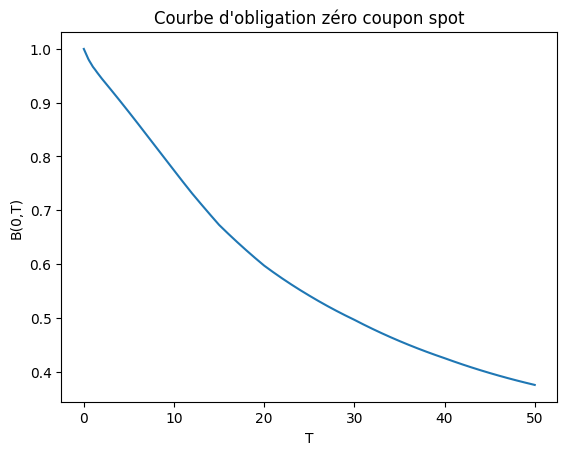

In [15]:
#pip install matplotlib
import matplotlib.pyplot as plt
plt.plot(essai['T'], essai['B(0,T)'])
plt.xlabel('T')
plt.ylabel('B(0,T)')
plt.title("Courbe d'obligation zéro coupon spot")
plt.show()

### Construction de la courbe de taux zéro coupon spot

La courbe de taux zéro coupon spot est donnée par la formule suivante:

$$r_T = -\frac{1}{T} \ln B(0,T)$$



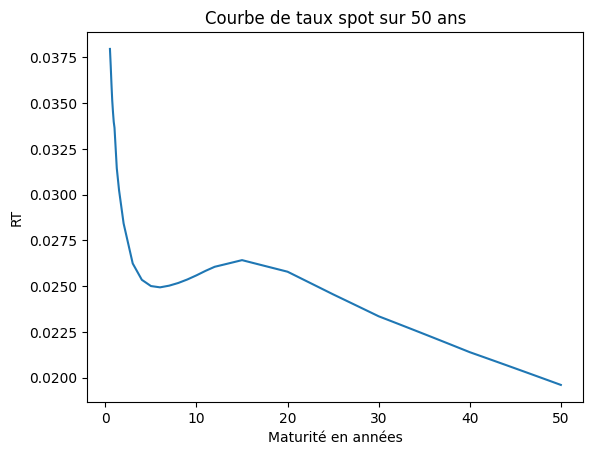

In [16]:
essai['RT'] = -np.log(essai['B(0,T)'])/essai['T']

#plot the cure

plt.plot(essai['T'], essai['RT'])
plt.xlabel('Maturité en années')
plt.ylabel('RT')
plt.title('Courbe de taux spot sur 50 ans')
plt.show()


# Valorisation d'une obligation

Dans cette partie, nous allons valoriser une obligation et nous allons mettre en exergue les notions de Dirty price et de Clean Price. Le Dirty price d'une obligation, comprend les intérêts courus sur l'obligation  entre le dernier paiement du coupon et la date de règlement. Autrement dit, si un investisseur souhaite acheter une obligation, au prix sale, il devra payer le prix propre, plus les intérêts courus. Le Clean price, quant à lui est la valeur marchande riait de l'obligation, sans aucun intérêt couru. La continuité de cette coupe montre qu'elle a un intérêt  économique et permet de se couvrir des risques. 

Le prix d'une obligation zéro-coupon(dirty price) est donné par la formule suivante:

$$P(t,T) = \sum_{i=1}^{T} \left[ c \cdot B(t,i) \cdot PS(i) \cdot \mathbf{1}_{(t < i)} \right] + B(t,T) \cdot PS(T) \cdot \mathbf{1}_{(t < T)}$$

Où $c$ est le coupon, $B(t,i)$ est le prix d'une obligation zéro-coupon à l'instant t et de maturité i, $PS(i)$ est le principal de l'obligation et $\mathbf{1}_{(t < i)}$ est la fonction indicatrice qui vaut 1 si t < i et 0 sinon.
$PS(i)=\exp(-s \cdot (i-t))$ où $s$ est le spread de crédit, représente la fonction de survie de l'obligation.

On supposera que la courbe de taux est déterministe:
Dans ce B(t,T) est donné par la formule suivante:
$$B(t,T) =\frac{B(0,T)}{B(0,t)}$$

Le prix du clean price est obtenu en soustrayant les intérêts courus à chaque date de paiement du coupon au dirty price. Il est donné par la formule suivante:

$$\text{Clean Price} = \text{Dirty Price} - c \cdot \left(t - \lfloor t \rfloor\right)$$
Où $\lfloor t \rfloor$ est la partie entière de t.	

In [17]:


def prix_obligation(t, c, s,T, data=essai):
    """
    Calcule le prix d'une obligation.
    
    Parameters:
    - t: Taux d'intérêt sans risque
    - c: Coupon de l'obligation
    - s:spread
    - T: Maturité de l'obligation
    
    Returns:
    - Prix de l'obligation
    """
    f_inte = interpolate.interp1d(essai['T'], essai['B(0,T)'])
    pt = 0
    for i in range(1,T+1):
        if t < i:
            
            B_t_i = f_inte(i)/f_inte(t)   
            ps_i = np.exp(-s*(i-t))
           
            pt += c *B_t_i * ps_i
    if t<T:
        B_t_T = f_inte(T)/f_inte(t)
        ps_T  = np.exp(-s*(T-t))
        pt   += B_t_T * ps_T   
    return pt


def clean_price(t, c, s,T, data=essai):
    """
    Calcule le prix d'une obligation.
    
    Parameters:
    - t: Taux d'intérêt sans risque
    - c: Coupon de l'obligation
    - s:spread
    - T: Maturité de l'obligation
    
    Returns:
    - Prix de l'obligation
    """
    f_inte = interpolate.interp1d(essai['T'], essai['B(0,T)'])
    pt = 0
    for i in range(1,T+1):
        if t < i:
            
            B_t_i = f_inte(i)/f_inte(t)   
            ps_i = np.exp(-s*(i-t))
           
            pt += c *B_t_i * ps_i 
    if t<T:
        B_t_T = f_inte(T)/f_inte(t)
        ps_T  = np.exp(-s*(T-t))
        pt   += B_t_T * ps_T   
    return pt - c*(t-np.floor(t))

def prix_obligation_shift(t, c, s,T, h,essai):
    """
    Calcule le prix d'une obligation.
    
    Parameters:
    - t: Taux d'intérêt sans risque
    - c: Coupon de l'obligation
    - s:spread
    - T: Maturité de l'obligation
    
    Returns:
    - Prix de l'obligation
    """
    f_inte = interpolate.interp1d(essai['T'], essai['B(0,T)'])
    pt = 0
    for i in range(1,T+1):
        if t < i:
            
            B_t_i = (f_inte(i)/f_inte(t))*(np.exp(-h*(i-t)))   
            ps_i = np.exp(-s*(i-t))
           
            pt += c *B_t_i * ps_i
    if t<T:
        B_t_T = (f_inte(T)/f_inte(t))*(np.exp(-h*(T-t)))
        ps_T  = np.exp(-s*(T-t))
        pt   += B_t_T * ps_T    
    return pt


def prix_obligation_spread(t, c, s,T, h,essai):
    """
    Calcule le prix d'une obligation.
    
    Parameters:
    - t: Taux d'intérêt sans risque
    - c: Coupon de l'obligation
    - s:spread
    - T: Maturité de l'obligation
    
    Returns:
    - Prix de l'obligation
    """
    f_inte = interpolate.interp1d(essai['T'], essai['B(0,T)'])
    pt = 0
    for i in range(1,T+1):
        if t < i:
            
            B_t_i = (f_inte(i)/f_inte(t))*(np.exp(-h*(i-t)))   
            ps_i = np.exp(-(s+h)*(i-t))
           
            pt += c *B_t_i * ps_i
    if t<T:
        B_t_T = (f_inte(T)/f_inte(t))*(np.exp(-h*(T-t)))
        ps_T  = np.exp(-(s+h)*(T-t))
        pt   += B_t_T * ps_T
    return pt


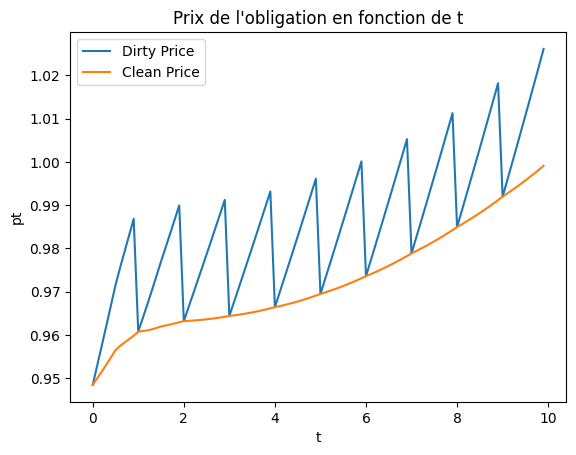

In [18]:
# Tracer pt en fonction de t pour c=0.03, s=0.01 et T=10 avec un pas de 0.1
coupon = 0.03
spread = 0.01
maturite = 10

plage_t = np.arange(0, 10, 0.1)
plage_pt = [prix_obligation(t, c=coupon, s=spread, T=maturite, data=essai) for t in plage_t]
plage_clean = [clean_price(t, c=coupon, s=spread, T=maturite, data=essai) for t in plage_t]

plt.plot(plage_t, plage_pt, label='Dirty Price')

plt.plot(plage_t, plage_clean, label='Clean Price')
plt.xlabel('t')
plt.ylabel('pt')
plt.title('Prix de l\'obligation en fonction de t')
plt.legend()
plt.show()

Sur la courbe ci-dessus, nous avons représenté le Dirty price en bleu et le clean price en orange. Nous remarquons que sur le Dirty price, il y a des décrochages, des discontinuités qui correspondent à l'intégration de coupons. Par contre, le clean prize qui correspond au Dirty price auquel on a retiré le coupon couru est continu et peut permettre une analyse de risques. 

## Sensibilité du prix d'une obligation en fonction du taux d'intérêt et du spread de crédit

Cette fois-ci, nous allons étudier la sensibilité du prix d'obligations en fonction du taux d'intérêt et le spread de crédit.

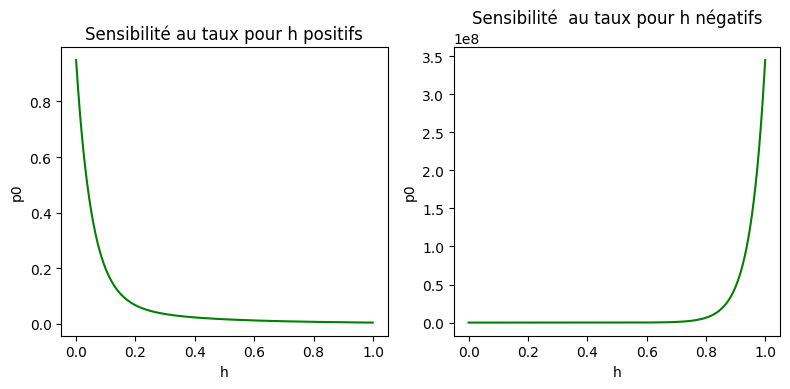

In [19]:
# Tracer pt en fonction de t pour c=0.03, s=0.01 et T=10 avec un pas de 0.1
temps_initial = 0

import numpy as np
import matplotlib.pyplot as plt

# Supposons que vos fonctions et variables sont déjà définies correctement

fig, ax = plt.subplots(1,2, figsize=(8,4))  # Crée une figure et deux subplots (axes)
plage_h = np.arange(0, 1, 0.001)


# Supposons que prix_obligation_spread soit votre fonction personnalisée
plage_pt_h = [prix_obligation_spread(temps_initial,coupon, spread, maturite, h, essai) for h in plage_h]
plage_pt__h = [prix_obligation_spread(temps_initial,coupon, spread, maturite, -h, essai) for h in plage_h]

# Utiliser les méthodes de l'objet Axes pour tracer
ax[0].plot(plage_h, plage_pt_h,color='green')
ax[1].plot(plage_h, plage_pt__h,color='green')

ax[0].set_xlabel('h')
ax[0].set_ylabel('p0')
ax[1].set_xlabel('h')
ax[1].set_ylabel('p0')

ax[0].set_title('Sensibilité au taux pour h positifs')
ax[1].set_title('Sensibilité  au taux pour h négatifs')

plt.tight_layout()  # Ajuste automatiquement le layout pour éviter le chevauchement
plt.show()



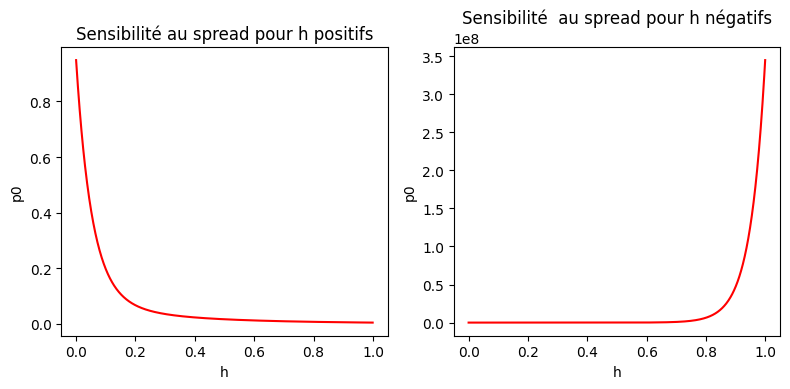

In [20]:
# Tracer pt en fonction de t pour c=0.03, s=0.01 et T=10 avec un pas de 0.1
temp_initial = 0
fig,ax = plt.subplots(1,2, figsize=(8,4))
plage_h = np.arange(0, 1, 0.001)
plage_pt_h = [prix_obligation_spread(temp_initial, coupon, spread, maturite, h, essai) for h in plage_h]
plage__pt_h = [prix_obligation_spread(temp_initial, coupon, spread, maturite, -h, essai) for h in plage_h]
ax[0].plot(plage_h, plage_pt_h,color='r')
ax[1].plot(plage_h, plage__pt_h,color='r')


ax[0].set_xlabel('h')
ax[0].set_ylabel('p0')
ax[1].set_xlabel('h')
ax[1].set_ylabel('p0')

ax[0].set_title('Sensibilité au spread pour h positifs')
ax[1].set_title('Sensibilité  au spread pour h négatifs')

plt.tight_layout()  # Ajuste automatiquement le layout pour éviter le chevauchement
plt.show()

Il en ressort des graphiques ci-dessus qu'une augmentation(diminution) du taux d'intérêt ou du spread de crédit conduit à une augmentation(diminution) du prix de l'obligation zéro coupon.

# Calcul de la duration à t =0 avec h = 0.00001

La formule de la duration est donnée par la formule ci-après:

$$D = -\frac{1}{P} \frac{P_h - P}{h}$$

La duration exprime comment un portefeuille est sensible aux variations des taux d'intérêts. Un portefeuille avec une duration de 5  signifie que si un peu d'intérêt augmente de 1% la valeur du portefeuille va diminuer de 5%. 
La duration de notre portefeuille est de 8,75, cela signifie que si le taux d'intérêt augmente de 1%, la valeur de notre portefeuille va diminuer de 8,75%. 

In [21]:
# Calcul de la duration
h = 0.0001
P_h = prix_obligation_shift(temp_initial, coupon, spread, maturite, h, essai)
P = prix_obligation(temp_initial, coupon, spread, maturite, essai)
D = -1/P * (P_h - P)/h

print(f"La duration de l'obligation est {D}")

La duration de l'obligation est 8.745296500323784


## Valorisation d'un  produit Exotique avec Hull White

Dans cette partie, nous allons dans un premier temps définir le prix de n'importe quel zéro-coupon c'est-à-dire trouver une forme analytique de B(t,T)-qui est le prix d'une obligation sans coupon définie par la valeur en t d'une unité monétaire payée à l'échéance. Ensuite, nous allons nous hedger contre le risque de taux d'intérêt en utilisant les caplets. Un caplet est une option d'achat sur un taux d'intérêt. Il est utilisé pour se protéger contre une hausse des taux d'intérêt. Nous allons calibrer sa volatilité. Enfin, nous utiliserons cette volatilité et des simulations de Monte Carlo pour calibrer les niveaux de strike. Nous savons par exemple que si le Libor est supérieur au strike, l'option est exercée.

### Calcul de B(t,T) avec Hull White

Le modèle de Hull et White est une extension du modèle de Vasicek. Sous le modèle de Hull et White, le taux court est donné par la formule suivante:
$$dr_t=\lambda (\theta -  r_t)dt+\sigma dW_t$$

Nous allons étudier la partie simplifiée avec $\lambda=0$

Montrer tout d'abord que :
La formule pour calculer \(B(t,T)\) est donnée par :

 $$B(t,T) = \frac{B(0,T)}{B(0,t)} \exp \left( -(T-t) X_t - \frac{1}{2} (T-t)^2 \sigma^2 t \right)$$

où l'équation différentielle stochastique pour \(X_t\) est :

$$dX_t = \sigma^2 t \, dt + \sigma dW_t$$

Nous avons déjà montrer dans le cours que :

$$B(t,T) = \frac{B(0,T)}{B(0,t)} \exp \left( -\beta(t,T) X_t - \frac{1}{2} \beta(t,T)^2 \phi(t) \right)$$

Avec :
$$\phi(t) =  \exp(-2\lambda t)*\int_0^t \sigma^2 \exp(2\lambda s) ds = \frac{\sigma^2}{2\lambda} (1-\exp(-2\lambda t))$$
et 
$$\beta(t,T) = \frac{1}{\lambda} (1-\exp(-\lambda(T-t)))$$

$$dX_t = (\phi(t)- \lambda X_t)dt + \sigma dW_t$$

Lorsque $\lambda=0$, nous avons :
$\phi(t) = \sigma^2 t$ et $\beta(t,T) = T-t$

Donc la formule pour calculer \(B(t,T)\) est donnée par :

$$B(t,T) = \frac{B(0,T)}{B(0,t)} \exp \left( -(T-t) X_t - \frac{1}{2} (T-t)^2 \sigma^2 t \right)$$
et
$$dX_t = \sigma^2 t \, dt + \sigma dW_t$$ 



### Calibration de la volatilité pour un strike K=4%, une maturité T=1 et $\delta$(la fraction de l'année) = 1/2

Le prix du caplet dans le modèle de Hull et White est donné par la formule suivante:

 $$\text{Caplet}^{HW1F} = B(0, T + \delta) \cdot \text{Black}\left(\text{Fwd} = \frac{B(0, T)}{B(0, T + \delta)}, \text{maturité} = T, \text{vol} = \sigma\delta, \text{Strike} = 1 + \delta K\right)$$

Et le prix du caplet du marché est obtenu par la formule suivante:

$$\text{Caplet}^{\text{Marché}} = \delta \cdot B(0, T + \delta) \cdot \text{Black}\left(\text{Fwd} = \frac{1}{\delta} \left( \frac{B(0, T)}{B(0, T + \delta)} - 1 \right), \text{maturité} = T, \text{vol} = \text{vol\_implicite}, \text{Strike} = K\right)$$

Black est la formule de Black Scholes qui est utilisée pour calculer le prix d'une option européenne et la vol_implicite est la volatilité implicite qui sera considérée égale à 25%.

Calibrer $\sigma$, revient à déterminer la volatilité qui fait correspondre le prix du caplet du marché au prix du caplet dans le modèle de Hull et White. Nous utiliserons pour ce fait la méthode de Newton.

In [22]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import newton

# Ecrire une fonction qui calcule le prix d'un call européen

def blackScholesCall(S,K,T,r,sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def prix_caplet(K,T,delta,sigma,data= essai):
    f_interpolation = interpolate.interp1d(data['T'], data['B(0,T)'])
    B_0_T_delta = f_interpolation((T + delta))
    B_0_T = f_interpolation(T)
    fwd = B_0_T/B_0_T_delta
    vol = sigma* delta
    strike = 1+delta*K
    black = blackScholesCall(S=fwd, K=strike, T=T, r=0, sigma=vol)
    prix_caplet = B_0_T_delta  * black
    return prix_caplet
    
def prix_caplet_maket(K,T,delta,sigma,data= essai):
    f_interpolation = interpolate.interp1d(data['T'], data['B(0,T)'])
    B_0_T_delta = f_interpolation((T + delta))
    B_0_T = f_interpolation(T)
    fwd = (B_0_T/B_0_T_delta-1)*(1/delta)
    black = blackScholesCall(S=fwd, K=K, T=T, r=0, sigma=sigma)
    prix_caplet_maket = B_0_T_delta  * black*delta
    return prix_caplet_maket

def implied_volatility(K,T,delta,sigma,data,prix_caplet_maket):
    difference = lambda sigma:np.abs( prix_caplet_maket - prix_caplet(K,T,delta,sigma,data))
    return newton(difference, sigma)

    

In [23]:
strike = 0.04
delta = 0.5
sigma = 0.25
prix_caplet_maket = prix_caplet_maket(K=strike,T=maturite,delta =delta,sigma=sigma,data = essai)

In [24]:
print(f"Le prix du caplet est {prix_caplet_maket:.6f}")

Le prix du caplet est 0.002126


In [25]:

sigma_calibre = implied_volatility(K=strike,T=maturite,delta =delta,sigma=sigma,data = essai,prix_caplet_maket = prix_caplet_maket)

print(f"La volatilité implicite est {sigma_calibre*100:.2f}%")

La volatilité implicite est 0.81%


### Simulation de Monte Carlo pour calibrer les niveaux de strike

Nous savons que le Libor entre deux instants i et i+1 est donné par la formule suivante:

$$L(i+1) = \frac{1}{\delta} \left( \frac{1}{B(0, {i+1})} - 1 \right)$$

Si nous utilisons la formule de générale de B(t,T) calculé précédemment avec t=i et T= i+1, nous obtenons la formule suivante:

$$L(i,i+1) = \frac{1}{\delta} \left( \frac{B(0,i)}{B(0, {i+1})} \exp(X_i + \frac{1}{2} \sigma^2 i) - 1 \right)$$

$\sigma$ est la volatilité de Hull et White que nous avons calibré précédemment.
Nous remarquons que, calibrer L revient à calibrer X qui est donnée par la formule suivante:

$$dX_t = \sigma^2 t \, dt + \sigma dW_t$$
Nous aurons pu calibrer X en prenant des pas très petits, comme dans le graphique ci-dessous, mais nous avons décidé de calibrer X avec des pas de 1 :

$$X_{i+1} = X_i + \sigma^2 (i+0.5) + \sigma Z$$

Où Z est une variable aléatoire suivant une loi normale centrée réduite.





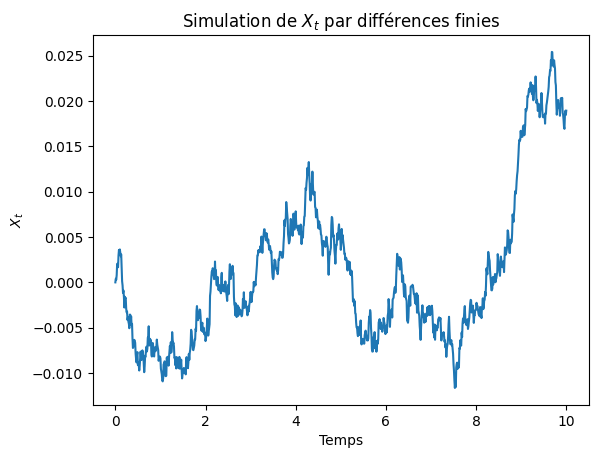

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de simulation
T = 10  # Temps final
N = 1000  # Nombre de pas
dt = T/N  # Pas de temps
sigma = sigma_calibre  # Volatilité

# Initialisation
t = np.linspace(0, T, N+1)
X = np.zeros(N+1)
Z = np.random.normal(0, 1, N)  # Génère N réalisations de N(0,1)

# Simulation par différences finies
for i in range(N):
    X[i+1] = X[i] + sigma**2 * t[i] * dt + sigma * np.sqrt(dt) * Z[i]

# Affichage
plt.plot(t, X)
plt.xlabel('Temps')
plt.ylabel('$X_t$')
plt.title('Simulation de $X_t$ par différences finies')
plt.show()


In [27]:

def simulation_monte_carlo(delta,sigma,essai,M,alpha):
    """La fonction simule le prix d'un caplet par la méthode de Monte Carlo

    Args:
        delta (float): Fréquence de paiement
        sigma (float): Volatilité
        essai (dataframe): ce dataframe contient les données des zéro coupon
        M (float): Nombre de simulations
        alpha (float): Taux de référence

    Returns:
        float: prix du caplet
    """
    mean_price = []
    for i in range(M):
        Z = np.random.normal(0, 1, 10)  # Génère N réalisations de N(0,1)
        X = np.zeros(11)
        f_interpolation = interpolate.interp1d(essai['T'], essai['B(0,T)'])
        L_i_iplus1 = np.zeros(10)
        for j in range(0,10):
            X[j+1] = X[j] + sigma**2*(j+0.5) + sigma*Z[j]
            
        j_values = np.arange(1, 11)  
        B_0_i = f_interpolation(j_values)
        B_0_i_plus_1 = f_interpolation(j_values + 1)
        
        exp_X_i_plus_sigma = np.exp(X[1:] + sigma**2*0.5*j_values)
        L_i_iplus1 = ((B_0_i / B_0_i_plus_1) * exp_X_i_plus_sigma - 1) * (1 / delta)
        meanl = np.mean(L_i_iplus1>alpha)
        mean_price.append(meanl)
    B_0_T = f_interpolation(10)
    return np.mean(mean_price)*B_0_T
        


In [28]:

delta = 0.5
sigma = sigma_calibre
data = essai
M = 10000
alpha = 0.03

simulation_monte_carlo(delta,sigma,data,M,alpha)

0.5707254427334494

#### variation du prix du caplet en fonction du seuil alpha

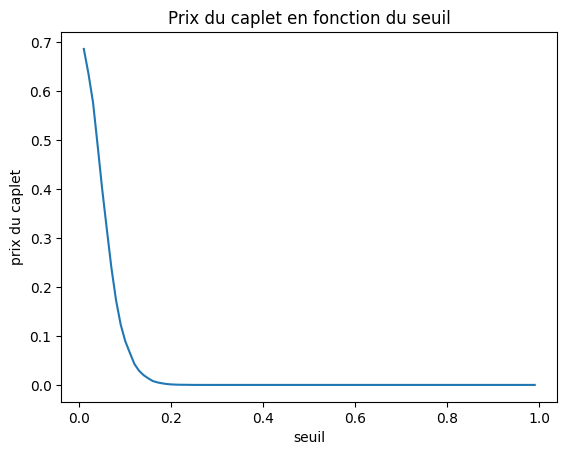

In [29]:
plage_alpha = np.arange(0.01, 1, 0.01)
plage_prix = [simulation_monte_carlo(delta,sigma,data,M,alpha) for alpha in plage_alpha]

plt.plot(plage_alpha, plage_prix)
plt.xlabel('seuil')
plt.ylabel('prix du caplet')
plt.title('Prix du caplet en fonction du seuil')
plt.show()


## Valorisation d'une obligation avec clause de rappel avec Hull White.

La valorisation d'une obligation avec une clause de rappel implique l'évaluation d'une obligation qui donne à l'émetteur le droit, mais pas l'obligation de rembourser le principal de l'obligation avant l'échéance à un prix prédéterminé, appelé prix de rappel, cette caractéristique offre à l'émetteur de l'obligation, la flexibilité de refinancer sa dette à un coût inférieur si les taux d'intérêt du marché baissent. 

Dans cette partie, avec un exemple  simple, nous allons valoriser le prix d'une option sur une obligation avec clause de rappel. Nous emploierons pour cela des simulations de Monte-Carlo afin de déterminer le prix de l'obligation avec clause de rappel. Par la suite, nous comparerons cette obligation à une obligation classique sans clause de rappel, afin de déterminer le prix d'une option de rappel elle-même. Enfin, nous procéderons à diverses analyses de sensibilité pour évaluer l'impact de différents facteurs sur la valorisation. 

### Modèle de Hull et White

Nous avons déjà montrer dans le cours que :

$$B(t,T) = \frac{B(0,T)}{B(0,t)} \exp \left(-(T-t) X_t - \frac{1}{2} (T-t)^2 \sigma^2 t \right)$$

Avec :
$$dX_t = \sigma^2 t \, dt + \sigma dW_t$$

si on pose $X_0 = 0$, nous avons :
En intégrant l'équation différentielle stochastique pour $X_t$, nous obtenons la formule suivante:
$$X_t = \sigma^2 \frac{t^2}{2} + \sigma W_t$$ 

Comme $W_t$ est un mouvement brownien, nous avons que $W_t$ est une variable aléatoire suivant une loi normale centrée de variance t.
donc si on pose $U =\sqrt{t}W_t$, nous avons que U est une variable aléatoire suivant une loi normale centrée de variance 1. Ainsi on trouve que notre modèle de Hull et White s'écrira sous la forme suivante:

$$B(t,T,U,\sigma) = \frac{B(0,T)}{B(0,t)} \exp \left(-(T-t)(\frac{1}{2} \sigma^2 t^2+\sigma \sqrt(t)U)- \frac{1}{2} (T-t)^2 \sigma^2 t \right)$$

Ainsi nous pouvons calibrer par monte-Carlo le prix de l'obligation avec clause de rappel.
Dans un prix temps la fonction de valorisation de l'obligation est donnée par la formule suivante:
$$P(t, T, U, \sigma) = \sum_{i=1}^{T} \left[ c \cdot B(t, i, U, \sigma) \cdot PS(i) \cdot \mathbf{1}_{(t < i)} \right] + B(t, T, U, \sigma) \cdot PS(T) \cdot \mathbf{1}_{(t < T)}$$

avec $PS(t)$ la fonction de survie qui est donnée par la formule suivante:
$$PS(i)=\exp(-s \cdot(i-t))$$

Le prix de l'obligation avec clause de rappel est donné par la formule suivante:

comment on écrire le minimum de deux valeurs dans une fonction mathématique en latex?

$$P(t,T,\sigma)^c = \frac{1}{N} \sum_{i=1}^{N}  \min \left( P(t, T, U, \sigma) , 1 \right)$$

Avec N le nombre de simulations.

Nous avons implémenté sur prix le code du ci-dessous.

In [30]:
import numpy as np

def B(t, T, U, sigma,data,h_taux,h_sigma):
    """
    Calcule la valeur de B(t, T, U, sigma) selon la formule spécifiée.

    Paramètres:
    - t : Temps actuel.
    - T : Temps final.
    - U : Variable aléatoire ou paramètre spécifique au modèle.
    - sigma : Volatilité.
    
    Retourne:
    - La valeur calculée de B(t, T, U, sigma).
    """
    f_inte = interpolate.interp1d(data['T'], data['B(0,T)'])
    B_0_T = f_inte(T)*np.exp(-h_taux*T)
    B_0_t = f_inte(t)*np.exp(-h_taux*t)
    sigma+=h_sigma
    exp_part = np.exp(-1 * (T - t) * (0.5 * sigma**2 * t**2 + sigma * np.sqrt(t) * U) - 0.5 * (T - t)**2 * sigma**2 * t)
    return (B_0_T / B_0_t) * exp_part


  

def prix_obligation_Hull_White(c,s,t,T,U,sigma,data,h_taux,h_sigma):
    """
    Calcule le prix d'une obligation.
    paramètres:
    - t: Taux d'intérêt sans risque
    - c: Coupon de l'obligation
    - s:spread
    - T: Maturité de l'obligation
    - U : Variable aléatoire ou paramètre spécifique au modèle.
    - sigma : Volatilité.
    - data : dataframe contenant les données
    Returns:
    - Prix de l'obligation

    """
    prix = 0
    for i in  range(1,T+1):
        if t<i:
            ps_i = np.exp(-s*(i-t))
            b_t_i = B(t,i,U,sigma,data,h_taux,h_sigma)
            prix += c*b_t_i*ps_i
    if t<T:
        ps_T = np.exp(-s*(T-t))
        b_t_T = B(t,T,U,sigma,data,h_taux,h_sigma)
        prix += b_t_T*ps_T
    return prix   
    
# simulation des prix

def simulation_prix(c,s,t,T,sigma,data,N,h_taux,h_sigma):
    liste_prix = []
    for i in range(N):
        U = np.random.normal(0,1)
        prix = prix_obligation_Hull_White(c,s,t,T,U,sigma,data,h_taux,h_sigma)
        liste_prix.append(prix)
    prix_ajuste = np.minimum(liste_prix,1)
    
    
    return np.mean(prix_ajuste)


In [31]:
Nombre_simulations = 10000
temps_exercice = 5
sigma =0.01

prix_c =simulation_prix(c=coupon,s=spread,t=temps_exercice,T=maturite,
                        sigma=sigma,data=essai,N=Nombre_simulations,
                        h_taux=0.01,h_sigma=0.01)
print(f"Le prix de l'obligation de rappel est de  {prix_c}")

Le prix de l'obligation de rappel est de  0.8625892100410947


### Calcul du prix de l'option de rappel

Nous avons initialement estimé la valeur d'une obligation zéro-coupon, sa clause de rappel Par la suite, la valorisation d'une obligation incorporant une clause de rappel a été réalisée.Afin de quantifier le coût de l'option de rappel, nous procéderons à la soustraction des 2 prix précédemment obtenus, puis à l'actualisation du résultat à la date d'exercices. Le prix de l'option de rappel est donné par la formule suivante:

$$\text{option} = B(0,t) \left[ P(t,T) - P(t,T,\sigma)^c \right]$$

Rappelons que P(t,T) est donné par la formule suivante:

$$P_t = \sum_{i=1}^{T} \left[ c \cdot B(t,i) \cdot PS(i) \cdot \mathbf{1}_{(t < i)} \right] + B(t,T) \cdot PS(T) \cdot \mathbf{1}_{(t < T)}
$$

Nous avons implémenté le prix de cette option dans le code ci-dessous.

In [32]:




# Créeons une fonction qui calcule le prix d'une option

def calcule_option(c,s,t,T,sigma,data,N,h_taux=0,h_sigma=0):
    fonction_interpolation = interpolate.interp1d(data['T'], data['B(0,T)'])
    B_0_t = fonction_interpolation(t)
    prix_c =simulation_prix(c,s,t,T,sigma,data,N,h_taux,h_sigma)
    prix = prix_obligation_shift(t, c, s,T, h_taux,data) 
    option = B_0_t * (prix - prix_c)
    return option

option = calcule_option(c=coupon,s=spread,t=temps_exercice,T=maturite,
                        sigma=sigma,data=essai,N=Nombre_simulations,
                        h_taux=0.01,h_sigma=0.01)
print(f"Le prix de l'option est {option}")

Le prix de l'option est 0.057582150134175704


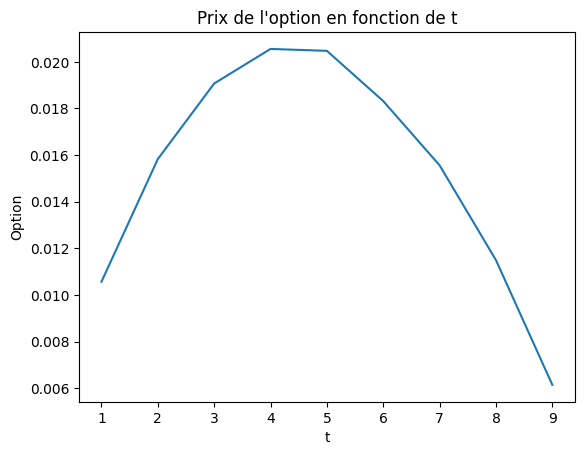

In [33]:
plage_t=np.arange(1,10)
plage_option = [calcule_option(c=coupon,s=spread,t=t,T=maturite,sigma=sigma_calibre,data=essai,N=Nombre_simulations) for t in plage_t]
    
plt.plot(plage_t, plage_option)
plt.xlabel('t')
plt.ylabel('Option')

plt.title('Prix de l\'option en fonction de t')

plt.show()

Le graphique ci-dessus présente le prix de l'option du rappel en fonction du temps. Nous remarquons que si l'émetteur exerce son option prématurément, il devra payer un prix plus élevé. Cependant, lorsqu'on se rapproche de la maturité de l'obligation, le prix de l'option de rappel diminue.

### Sensibilité du prix de l'option de rappel en fonction de la date d'exercie, de la volatilité et du taux d'intérêt.

#### Sensibilité du prix de l'option de rappel en fonction de la volatilité.

Le code ci-dessous représente la sensibilité du prix de l'option en fonction de la volatilité.
Comme nous pouvons le constater, une augmentation de la volatilité conduit à une augmentation du prix de l'option de rappel.

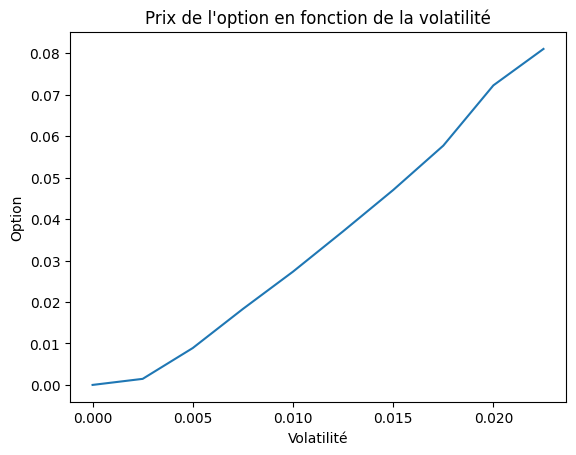

In [34]:
# Je veux une plage de volatilité {0%,0.25%,0.5%,...,5%}
pas = 0.25 / 100
plage_sigma =  np.arange(0, 10 * pas, pas)
plage_option_sigma = [calcule_option(c=0.03,s=0.01,t=5,T=10,sigma=sigma,data=essai,N=10000) for sigma in plage_sigma]
plt.plot(plage_sigma, plage_option_sigma)
plt.xlabel('Volatilité')
plt.ylabel('Option')
plt.title('Prix de l\'option en fonction de la volatilité')
plt.show()

#### Sensibilité du prix de l'option de rappel en fonction du taux d'intérêt.

Le code ci-dessous représente la sensibilité du prix de l'option en fonction du taux d'intérêt.
Comme nous pouvons le constater, une augmentation du taux d'intérêt conduit à une diminution du prix de l'option de rappel. Nous remarquons quelques décrochages qui peuvent être dus à la simplicité de la modélisation.

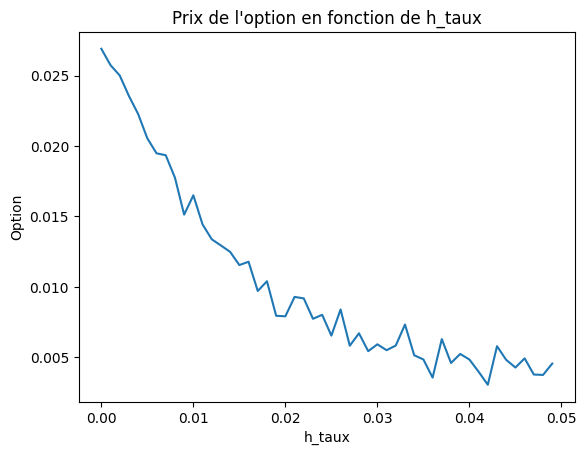

In [35]:
plage_h_taux = np.arange(0, 0.05, 0.001)
plage_option_h_taux = [calcule_option(c=0.03,s=0.01,t=5,T=10,sigma=0.01,data=essai,N=10000,h_taux=h_taux) for h_taux in plage_h_taux]
plt.plot(plage_h_taux, plage_option_h_taux)
plt.xlabel('h_taux')
plt.ylabel('Option')
plt.title('Prix de l\'option en fonction de h_taux')
plt.show()

#### Sensibilité du prix de l'option : Delta et Vega.

- Le delta est la sensibilité du prix de l'option par rapport au sous-jacent qui est ici le taux d'intérêt. Il est donné par la formule suivante:

$$\Delta =\frac{option_{h}-option}{h}$$

Où $option_{h}$ est le prix de l'option avec un taux d'intérêt augmenté de h.

Il peut aussi être utilisé pour se couvrir contre le risque de taux d'intérêt.


- Le Vega est la sensibilité du prix de l'option par rapport à la volatilité. Il est donné par la formule suivante:

$$\text{Vega} =\frac{option_{\sigma+h}-option_{\sigma}}{h}$$

Où $option_{\sigma+h}$ est le prix de l'option avec une volatilité augmentée de h.

Une obligation avec un Vega null est moins sensible à la volatilité du taux d'intérêt.

Le code ci-dessous permet d'implémenter le calcul du delta et du vega.

In [36]:
sigma = 0.01
h =0.00001
option_h = calcule_option(c=coupon,s=spread,t=temps_exercice,T=maturite,
                        sigma=sigma,data=essai,N=Nombre_simulations,
                        h_taux=h,h_sigma=0.01)
option_0 = calcule_option(c=coupon,s=spread,t=temps_exercice,T=maturite,
                        sigma=sigma,data=essai,N=Nombre_simulations,
                        h_taux=0,h_sigma=0.01)
delta = (option_h - option_0) /h
print(f"Le delta de l'option est {delta:.2f}")

Le delta de l'option est 50.07


In [37]:
# Calcul des Vega
h = 0.0001
option_haut = calcule_option(c=coupon,s=spread,t=temps_exercice,T=maturite,
                        sigma=sigma,data=essai,N=Nombre_simulations,
                        h_taux=0,h_sigma=h)
option_bas = calcule_option(c=coupon,s=spread,t=temps_exercice,T=maturite,
                        sigma=sigma,data=essai,N=Nombre_simulations,
                        h_taux=0,h_sigma=0)
                            
                            
vega = (option_haut - option_bas) / h
print(f"Le vega de l'option est {vega:.2f}")

Le vega de l'option est 2.83


# Conclusion

Dans ce document, l'accent a été mis sur la valorisation des obligations. Initialement, nous avons élaboré une courbe d'obligation zéro-coupon simplifiée, à partir de laquelle nous avons pu extrapoler la courbe des taux zéro-coupon. Nous avons procédé sous l'hypothèse d'une courbe de taux déterministe, ce qui a facilité l'examen des concepts de prix sale (Dirty Price) et de prix propre (Clean Price), chacun présentant ses propres avantages et inconvénients. Par exemple, le prix propre est souvent privilégié dans l'analyse des risques. Nous avons également exploré comment le prix des obligations varie en fonction des changements de taux et de spread, constatant que le prix d'une obligation tend à augmenter avec le taux d'intérêt et le spread. Nous avons observé une duration de 8%, indiquant qu'une hausse de 1% des taux d'intérêt entraînerait une baisse de 8% de la valeur de l'obligation. Nous avons également utilisé un modèle simplifié de Hull et White pour valoriser une option de caplet et une option avec clause de rappel.

